[Chapter 6] Feature Importance Analysis

100
0.6768482413039298
0.00495905524173486 0.001336992566937976
0.003455970753593775 0.0015130170794676566


<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


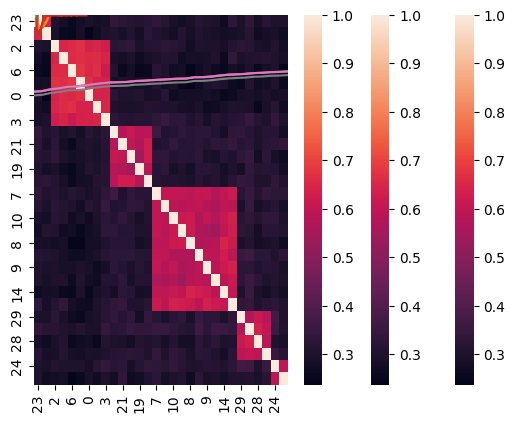

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
import statsmodels.discrete.discrete_model as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection._split import KFold

import matplotlib.pyplot as plt
import seaborn as sns

import import_ipynb
from ch4 import clusterKMeansBase

motivation - a numerical example

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


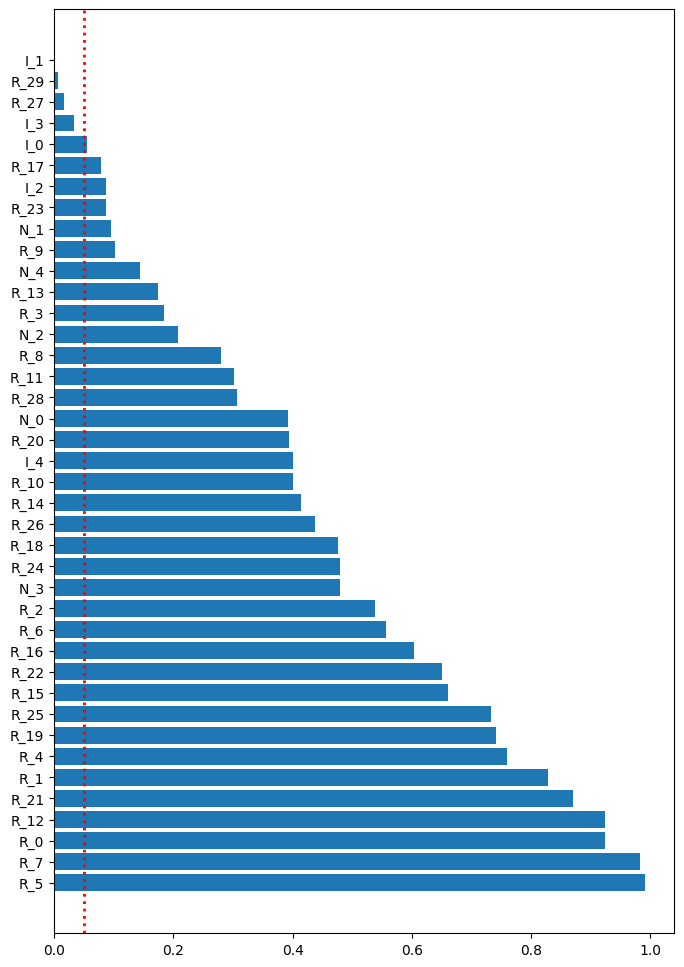

In [3]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=.0):
    """
    generate a random dataset of informed, redundant, and noise explanatory variables for a classification problem
    """
    np.random.seed(random_state)

    X, y = make_classification(n_samples=n_samples, n_features=n_features-n_redundant,
        n_informative=n_informative, n_redundant=0, shuffle=False, random_state=random_state)
    
    # I_: informative features (used to generate labels)
    cols = ['I_'+str(i) for i in range(n_informative)]
    
    # N_: noise features (that are not used to generate labels)
    cols += ['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]

    # R_: redundant features
    # formed by adding Gaussian noise to a randomly chosen informative feature
    X, y = pd.DataFrame(X, columns=cols), pd.Series(y)
    # randomly choosen informative feature
    i = np.random.choice(range(n_informative), size=n_redundant)
    # the lower the sigmaStd, the greater the substitution effect (cannot discriminate among redundant variables)
    for k, j in enumerate(i):
        X['R_'+str(k)] = X['I_'+str(j)] + np.random.normal(size=X.shape[0])*sigmaStd 
    
    return X, y


# example
X, y = getTestData(40, 5, 30, 10000, sigmaStd=0.1)
ols = sm.Logit(y, X).fit()

# p-vlaues of X
pvals = ols.pvalues.drop('const', errors='ignore').sort_values(ascending=False)
plt.figure(figsize=(8, 12))
plt.barh(pvals.index, pvals.values)
# add a red dotted vertical line at x = 0.05 (significance level)
plt.axvline(x=0.05, color='red', linestyle='dotted', linewidth=2)

feature importance - an ensemble MDI(mean-decrease impurity) method

In [4]:
def featImpMDI(fit, featName):
    """"
    compute feature importance based on IS mean impuriy reduction
    """
    # dict where 1) keys (i) are integer indices of trees i 
    #            2) values (tree.features_importances_) are feature importance array of each tree
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    # convert dict df0 to df df0 (with shape of num of trees x num of features)
    # rows correspond to trees i, columns correspond to features, each cell is the importance of that feature in that tree
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    
    # set the columns of the df df0 to the human-readable feature names passed in featName
    df0.columns=featName

    # replaces zeros with NaN
    # when max_features=1 (random select 1 feature at each split), many features may have zero importance in a given tree
    # using NaN excludes these zero values from calculations of mean and standard deviation
    #   avoiding skewing results with zeros (because an absence of split means no importance).
    df0 = df0.replace(0, np.nan) # because max_features=1

    # mean: the mean feature importance across all trees (ignore NaNs)
    # std: the standard deviation of feature importances divided by the square root of number of trees (df0.shape**-.5)
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std()*df0.shape[0]**-.5}, axis=1) #CLT(Central Limit Theorem)

    # normalizes the feature importance DataFrame by dividing every value by the sum of mean importances
    # ensure the sum of all feature mean importances equals 1
    # standard errors are scaled appropriately to preserve relative proportions
    imp /= imp['mean'].sum()

    # return normalized mean feature importances and their standard errors
    return imp

<BarContainer object of 40 artists>

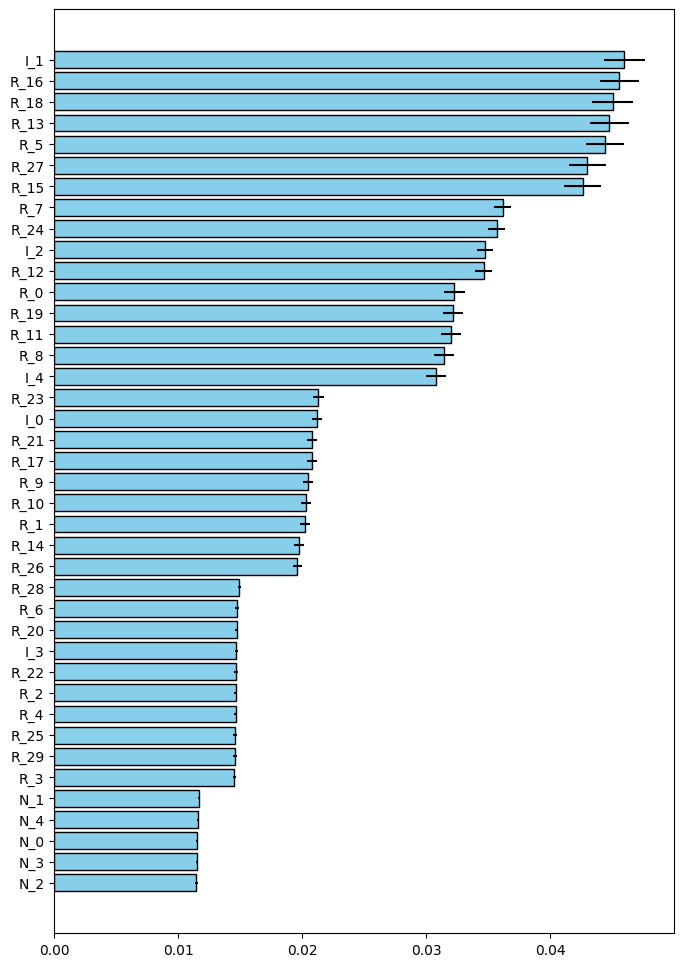

In [5]:
# test
# generate data
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)

# create a Decision Tree classifier with
# criterion='entropy': uses information gain (entropy) to split nodes.
# max_features=1: each split considers only 1 feature randomly (adds randomness).
# class_weight='balanced': automatically adjusts weights inversely proportional to class frequencies (useful if classes are imbalanced).
# min_weight_fraction_leaf=0: no restriction on minimum fraction of samples per leaf.
clf = DecisionTreeClassifier(criterion='entropy', max_features=1,
                             class_weight='balanced', min_weight_fraction_leaf=0)


# wrap the single decision tree clf with BaggingClassifier to create an ensemble of trees trained on bootstrap samples.
#    estimator=clf: base decision tree from above
#    n_estimators=1000: number of base trees in the ensemble (a large forest)
#    max_features=1.: each base estimator uses 100% of features (because 1. means 100%, not the same as single feature — careful difference from DecisionTreeClassifier's param).
#    max_samples=1.: each base estimator is trained on 100% of samples, but with bootstrap sampling by default.
#    oob_score=False: out-of-bag scoring disabled.
# the ensemble adds randomness and reduces overfitting compared to a single tree.
clf = BaggingClassifier(estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
fit = clf.fit(X, y)

# compute feature importance
imp = featImpMDI(fit, featName=X.columns)

# visualization
imp_sorted = imp.sort_values('mean', ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'], color='skyblue', edgecolor='k')

# after applying the MDI, it works better given all nonnoisy features (I_， R_) are ranked higher than noise features (N_)

# MDI method deals with 3 (out of 4 caveats of p-values):
# - no strong distributional assumptions that could be false (not imposing a particular tree structure or algebraic specification)
# - betas are estimated on single sample, ensemble MDIs are derived from a bootstrap of trees (the variance of estimates reduced by increasing num of trees in ensemble methods in general, or in random forest)
# - MDI finds the important features in general, irrespective of any particular parametric specification

# an ensemble estimate of MDI will exihibit low variance given a sufficient num of trees, reducing the concern of p-hacking.
#   but it does not invovle cross-validation. MDI is also computed in-sample.

feature importance - mean-decrease accuracy

In [31]:
def featImpMDA(clf, X, y, n_splits=10):
    """"
    feature importance based on OOS score reduction
    - clf: classifier with fit and predict_proba methods
    - X: dataFrame of features
    - y: target vector
    - n_splits: number of folds for cross-validation (default 10)
    """
    # initializes a K-Fold cross-validation splitter
    cvGen = KFold(n_splits=n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    
    # for each cross-validation fold
    for i, (train, test) in enumerate(cvGen.split(X=X)):

        # split data into training (X0, y0) and test (X1, y1) sets
        X0, y0 = X.iloc[train,:], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        
        # fit the calssifier on training data
        fit = clf.fit(X=X0, y=y0)
        
        # prediction before shuffling (on unshuffled test set)
        prob = fit.predict_proba(X1)
        
        # calculates negative log loss (higher values = better performance) and stores as baseline in scr0
        scr0.loc[i] = - log_loss(y1, prob, labels=clf.classes_)
        
        # for each feature j
        for j in X.columns:
            # make a copy of test data
            X1_ = X1.copy(deep=True)
            # randomly shuffle the values in column j, breaking the relationship between the feature j and the target.
            np.random.shuffle(X1_[j].values)
            # predict on this shuffled test set
            prob = fit.predict_proba(X1_)
            # store the negative log loss performance in scr1 for this fold and feature
            scr1.loc[i, j] = - log_loss(y1, prob, labels=clf.classes_)

    # computes the difference (scr0-scr1) higher value means higher reduction after shuffling
    imp = (-1*scr1).add(scr0, axis=0)

    # normalize as relative drop
    imp = imp/(-1*scr1)
    
    # aggregate importance estimates across folds
    # mean: Average importance per feature across all CV splits
    # std: Standard error of this mean, using the Central Limit Theorem adjustment
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std()*imp.shape[0]**-.5}, axis=1) # CLT

    return imp

C:\Users\user\AppData\Local\Temp\ipykernel_18288\2411863331.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)


<BarContainer object of 40 artists>

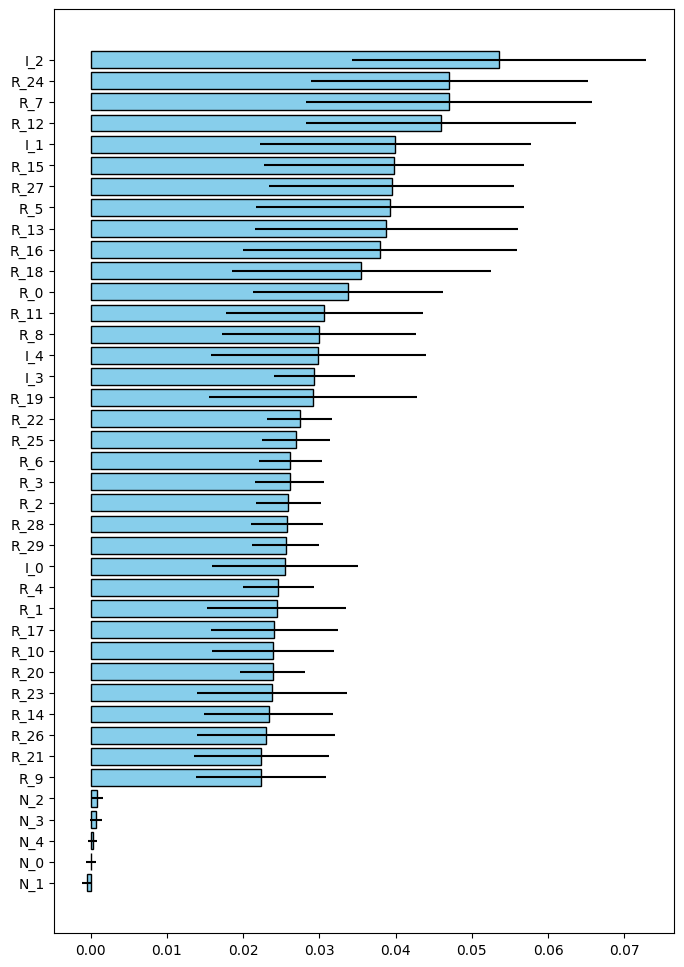

In [32]:
# test
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
imp = featImpMDA(clf, X, y, 10)

# visualization
imp_sorted = imp.sort_values('mean', ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'], color='skyblue', edgecolor='k')

# MDA does a good job overall in seperating noise features from the rest (N_ with MDA values of almost zero)
# subsitution effects contribute to higher variance in MDA importance, none is high enough to question the importance of nonnoise features

cluster feature importance

In [11]:
# clustered MDI

def groupMeanStd(df0, clstrs):
    out = pd.DataFrame(columns=['mean','std'])
    for i, j in clstrs.items():
        df1 = df0[j].sum(axis=1)
        out.loc['C_'+str(i), 'mean'] = df1.mean()
        out.loc['C_'+str(i), 'std'] = df1.std()*df1.shape[0]**-.5
    return out

#--------------------------------------------------------------------------

def featImpMDI_Clustered(fit, featNames, clstrs):
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan) # because max_features=1
    imp = groupMeanStd(df0, clstrs)
    imp /= imp['mean'].sum()
    return imp

In [16]:
# clustered MDA

def featImpMDA_Clustered(clf, X, y, clstrs, n_splits=10):
    cvGen = KFold(n_splits=n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=clstrs.keys())
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0 = X.iloc[train,:], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        for j in scr1.columns:
            X1_ = X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle all the features of a given cluster (instead of shuffling one feature at a time)
            prob = fit.predict_proba(X1_)
            scr1.loc[i, j] = - log_loss(y1, prob, labels=clf.classes_)
    imp = (-1*scr1).add(scr0, axis=0)
    imp = imp/(-1*scr1)
    imp = pd.concat({'mean':imp.mean(), 'std': imp.std()*imp.shape[0]**-.5}, axis=1)
    imp.index = ['C_'+str(i) for i in imp.index]
    return imp 

Experimental Results

<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


<Axes: >

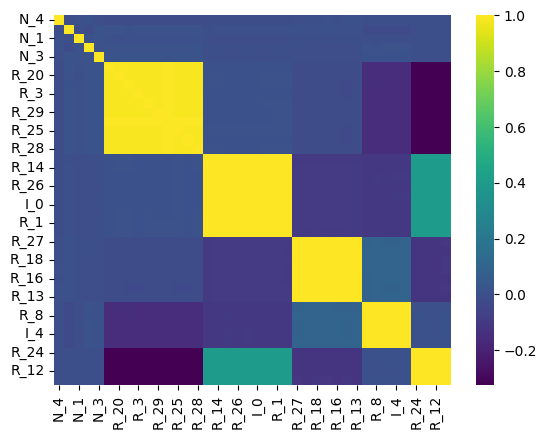

In [13]:
# feature clustering step
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)
corr0, clstrs, silh = clusterKMeansBase(X.corr(), maxNumClusters=10, n_init=10)
sns.heatmap(corr0, cmap='viridis')
# ONC correctly recognizes 6 relevant cluster 
#   (5 x 1 cluster for each I_ feature together with relevant R_ feature + 1 cluster of noise feature)

<BarContainer object of 6 artists>

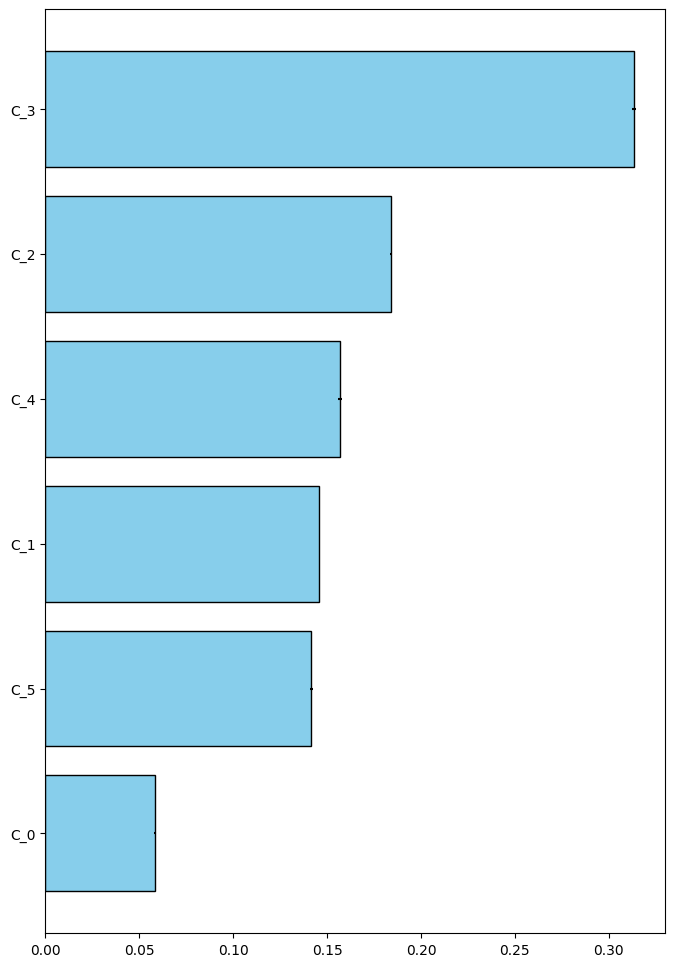

In [ ]:
# apply clustered MDI
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
fit = clf.fit(X, y)
imp = featImpMDI_Clustered(fit, X.columns, clstrs)

# visualization
imp_sorted = imp.sort_values('mean', ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'], color='skyblue', edgecolor='k')

# C_5 is cluster associated with the noise features
# reach 2 correct conclusions: 
# 1) C_5 is of almost zero importance 
# 2) all other clusteres have very similar importance (in contrast with less similarity under unclustered MDI)

C:\Users\user\AppData\Local\Temp\ipykernel_21044\4007164750.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=clstrs.keys())


<BarContainer object of 6 artists>

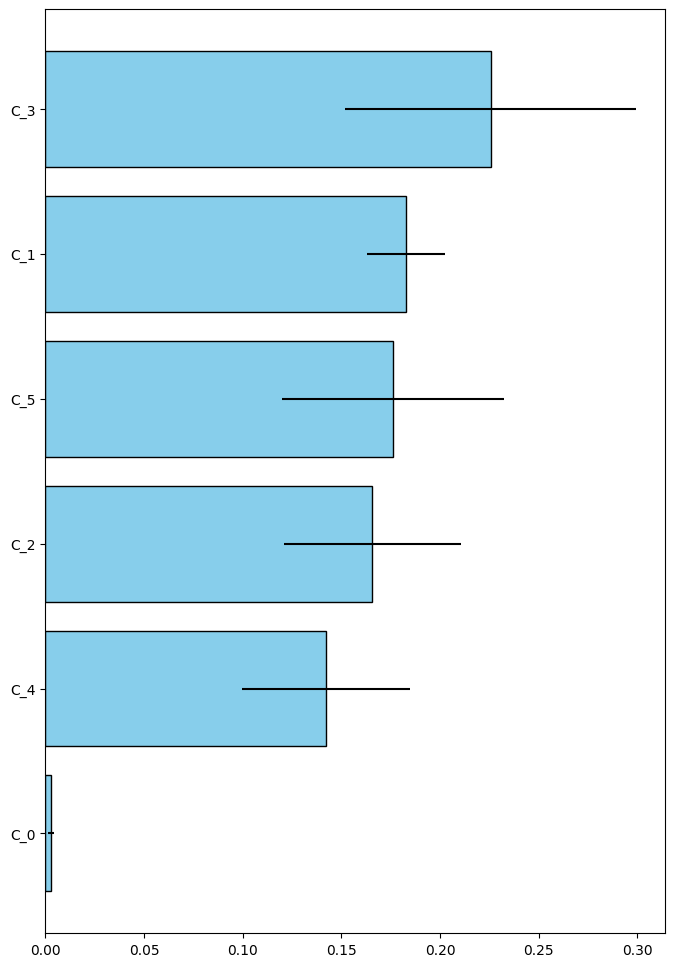

In [ ]:
# apply clustered MDA
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
fit = clf.fit(X, y)
imp = featImpMDA_Clustered(fit, X, y, clstrs, 10)

# visualization
imp_sorted = imp.sort_values('mean', ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'], color='skyblue', edgecolor='k')

# MDI and MDA assess the importance of features robustly without making assumptions about the distribution and structure of te data
# unlike p-values,
# - MDA evaluates feature importance in the cross-validated experiments
# - clustred MDI and clustered MDA estimates effectively control for substitution effects
# - ML techniques like MDI and MDA evaluate the importance of a feature irrespective of any particular specification

# Not only can ML feature importance methods be as helpful as p-values, but in some cases they can be more insightful and accurate  